# Tarea 4. Modelos lineales

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://storage.needpix.com/rsynced_images/bayesian-2889576_1280.png" width="200px" height="180px" />

En esta cuarta tarea, tendrás la oportunidad de estimar una relación cúbica usando un modelo lineal Bayesiano. Para esto usarás los datos en `data/Howell1`, considerando personas de todas las edades.

Por favor, intenta ser lo más explícit@ posible, y en lo posible, apóyate de la escritura matemática con $\LaTeX$.

Recuerda además que ante cualquier duda, me puedes contactar al correo esjimenezro@iteso.mx.

<p style="text-align:right;"> Imagen recuperada de: https://storage.needpix.com/rsynced_images/bayesian-2889576_1280.png.</p>

___

### Librerías:

In [130]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pymc as pm
import arviz as az
import numpy as np

### Creación del dataframe e información general:

In [131]:
howell = pd.read_csv('data/Howell1.csv', sep= ';')
howell.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [132]:
howell.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


## 1. 

Describir el modelo usando el lenguaje probabilístico visto en clase. Asegurarse, mediante una simulación predictiva previa que las previas son plausibles.

**Ayuda**. Estandarizar el peso antes.

### Estandarizar el peso:

In [133]:
sscaler = StandardScaler()

In [134]:
howell['weight'] = sscaler.fit_transform(howell['weight'].values.reshape(-1, 1))
howell['weight']

0      0.830633
1      0.059514
2     -0.254717
3      1.185347
4      0.385312
         ...   
539   -0.304840
540    1.125586
541    1.254748
542   -1.874067
543    1.150647
Name: weight, Length: 544, dtype: float64

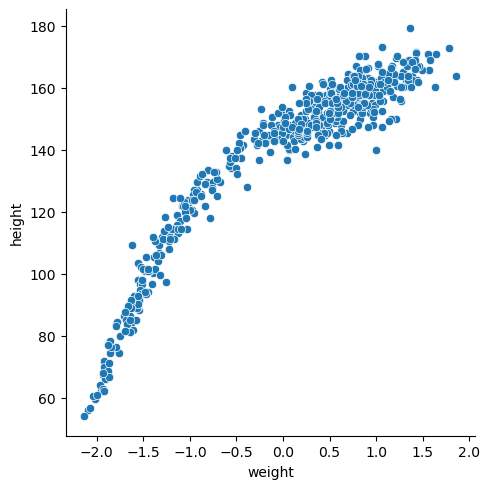

In [135]:
sns.relplot(x = 'weight', y = 'height', data = howell, kind= 'scatter')

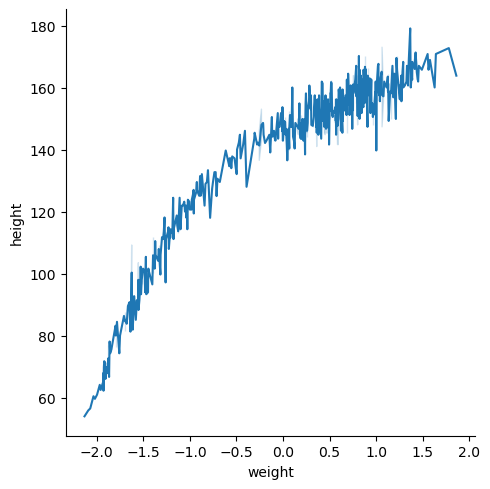

In [136]:
sns.relplot(x = 'weight', y = 'height', data = howell, kind= 'line')

Con esta información, podemos concluir que la función que modela la altura con los pesos estandarizados puede expresarse como:

$$h_i \sim \text{Normal}(\mu_i, \sigma)$$  

$$\mu_i = \alpha + \beta_1 w_i + \beta_2 w_i^2 + \beta_3 w_i^3$$  

$$\alpha \sim \text{Normal}(140,20)$$

$$\beta_1 \sim \text{LogNormal}(0,10)$$

$$\beta_2 \sim \text{Normal}(0,10)$$

$$\beta_3 \sim \text{Normal}(0,10)$$

$$\sigma \sim \text{Uniform}(0,40)$$

Donde:
 - $w_i$ es el peso estandarizado de la persona
 - $\bar{w}$ es el promedio de pesos

### Visualizamos la relación cúbica:

Text(0, 0.5, 'Height')

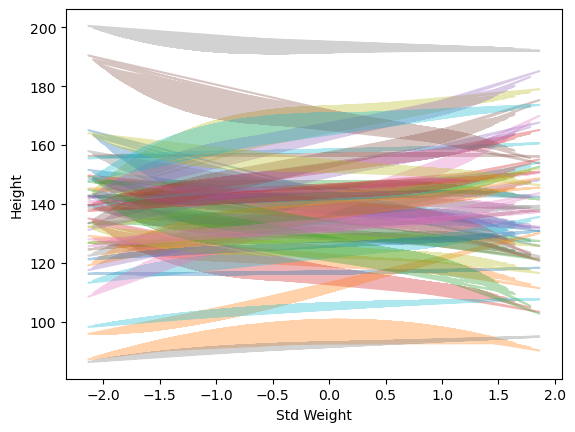

In [137]:
n_samples = 50
w = howell['weight'].values


alpha = stats.norm.rvs(loc=140, scale=20, size=n_samples).reshape(-1, 1)  
beta1 = stats.lognorm.rvs(s=1, size=n_samples).reshape(-1, 1)  
beta2 = stats.norm.rvs(loc=0, scale=1, size=n_samples).reshape(-1, 1)  
beta3 = stats.norm.rvs(loc=0, scale=1, size=n_samples).reshape(-1, 1)  
mu = alpha + beta1*w + beta2*w**2 + beta3*w**3

for i in range(50):  
    plt.plot(howell['weight'], mu[i, :], alpha=0.35)
plt.xlabel('Std Weight')
plt.ylabel('Height')

## 2.

Encontrar la distribución posterior de los parámetros. ¿Qué puede concluir de cada uno de ellos?

In [138]:
with pm.Model() as height_model:
    sigma = pm.Uniform('sigma', 0 , 50)
    alpha = pm.Normal('alpha', mu=140, sigma=20)
    beta_1 = pm.Lognormal('beta_1', mu = 0, sigma=1)
    beta_2 = pm.Normal('beta_2', mu = 0, sigma=1)
    beta_3 = pm.Normal('beta_3', mu = 0, sigma=1)

    mu = alpha + beta_1*w + beta_2*w**2 + beta_3*w**3

    height= pm.Normal('height', mu = mu, sigma = sigma, observed = howell['height'].values)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta_1, beta_2, beta_3]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


### ¿Cómo se ven estos datos?

In [139]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,146.389,0.319,145.781,146.976,0.006,0.004,2644.0,2278.0,1.0
beta_2,-6.189,0.256,-6.680,-5.712,0.006,0.004,2160.0,2258.0,1.0
beta_3,3.571,0.224,3.105,3.967,0.006,0.004,1562.0,1837.0,1.0
sigma,4.858,0.147,4.580,5.133,0.003,0.002,3325.0,2670.0,1.0
beta_1,15.209,0.471,14.298,16.045,0.011,0.008,1814.0,2282.0,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_3'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'beta_1'}>, <Axes: >]], dtype=object)

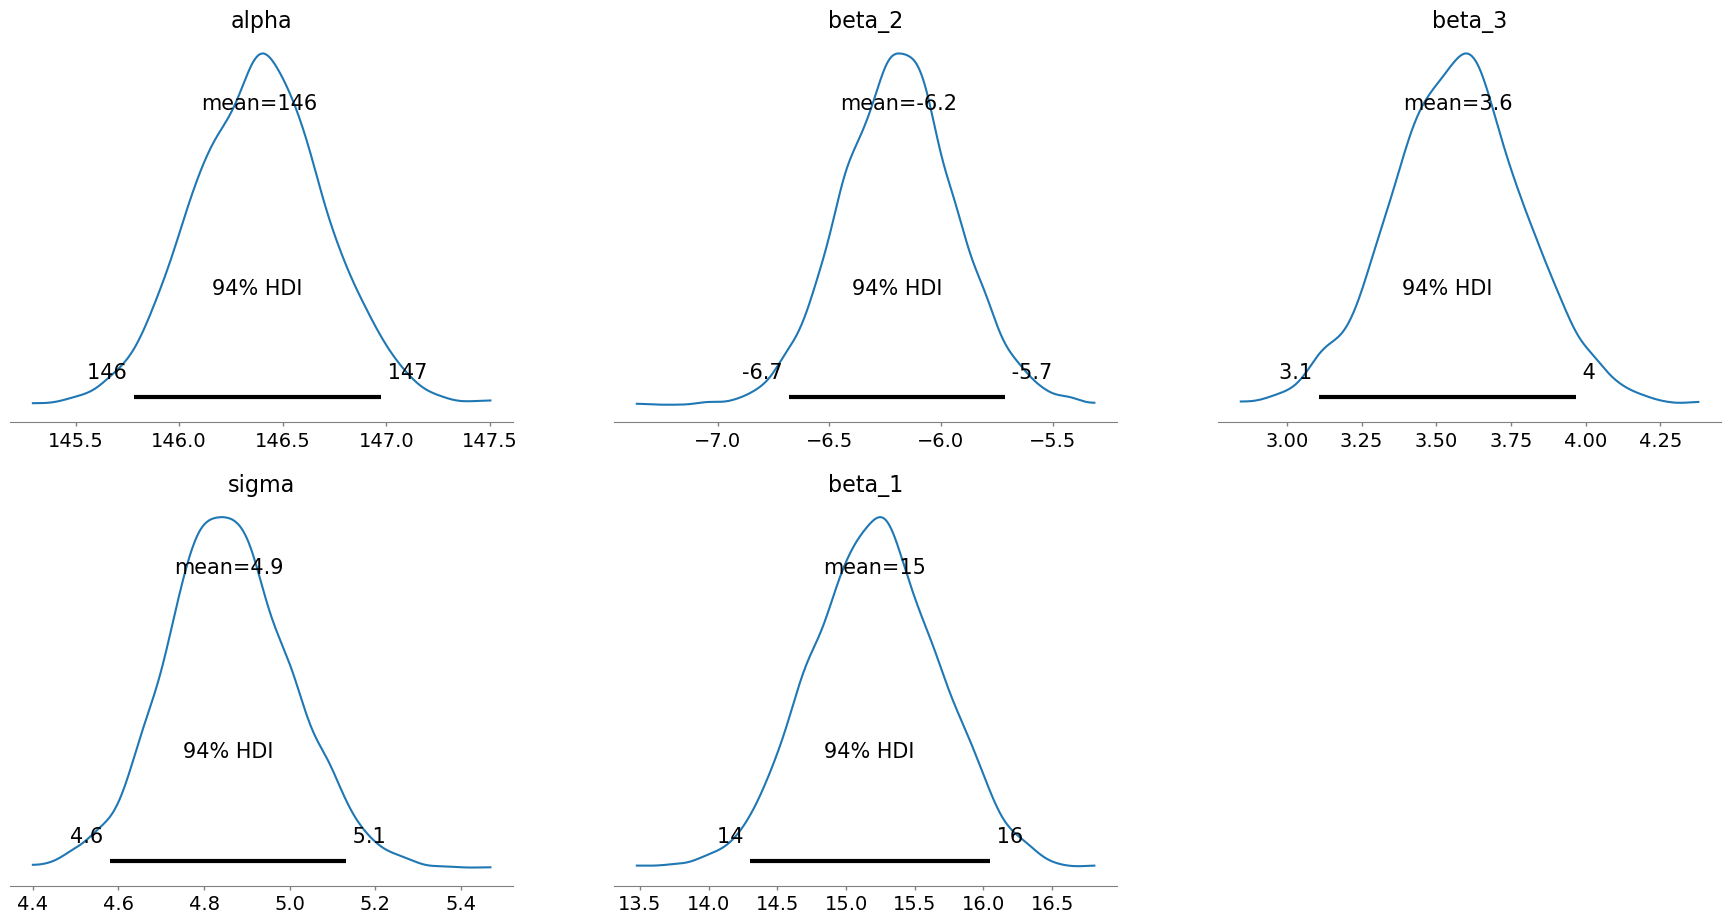

In [140]:
az.plot_posterior(idata)

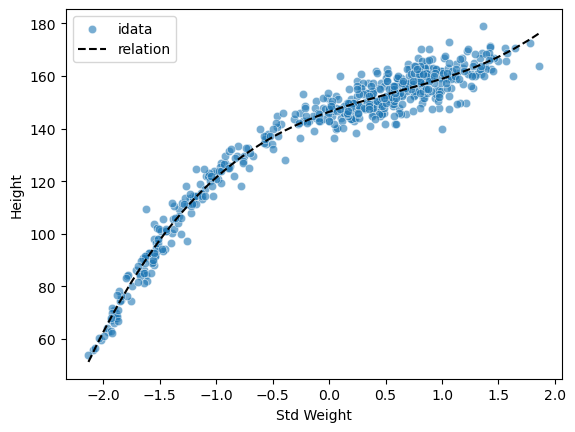

In [141]:
w_sorted = np.sort(w)

alpha_avg = idata.posterior['alpha'].mean().item()
beta1_avg = idata.posterior['beta_1'].mean().item()
beta2_avg = idata.posterior['beta_2'].mean().item()
beta3_avg = idata.posterior['beta_3'].mean().item()

mu_avg = (alpha_avg + beta1_avg*w_sorted + beta2_avg*w_sorted**2 + beta3_avg*w_sorted**3)

sns.scatterplot(x = 'weight', y = 'height', alpha = 0.6, data = howell, label = 'idata')
plt.plot(w_sorted, mu_avg, label='relation', linestyle = '--', color = 'black')
plt.xlabel('Std Weight')
plt.ylabel('Height')
plt.legend()


Se puede creer que el modelo hace un buen trabajo al describir los datos.

## 3.

¿Cuál es la distribución de la altura promedio de un infante de 10kg según tu modelo y los datos?

In [142]:
posterior = idata.posterior.to_dataframe()
posterior

alpha    beta_2    beta_3     sigma     beta_1
chain draw                                                     
0     0     146.272744 -5.918899  3.564021  4.645561  15.232278
      1     146.332775 -6.328402  3.418406  4.699417  15.269399
      2     146.360292 -6.128611  3.379859  4.807319  15.626738
      3     146.581505 -6.134229  3.438719  4.729693  15.813530
      4     146.370971 -6.136408  3.314663  4.810961  15.764925
...                ...       ...       ...       ...        ...
3     995   146.403104 -6.385292  3.528289  4.618517  15.225224
      996   146.220049 -5.920543  3.662512  4.950381  15.473330
      997   146.266525 -5.908502  3.567373  4.886996  15.223306
      998   145.863686 -6.135576  3.700263  4.835001  15.024902
      999   146.577654 -5.975826  3.666805  5.057150  15.474474

[4000 rows x 5 columns]

Antes de introducir el valor al modelo, debemos estandarizar el peso

In [143]:
weight_infant = sscaler.transform(np.array(10).reshape(1, -1))
weight_infant

array([[-1.74155031]])

In [144]:
mu_infant = posterior['alpha'].values + posterior['beta_1'].values * weight_infant + posterior['beta_2'].values * (weight_infant**2) + posterior['beta_3'].values * (weight_infant**3)
mu_infant

array([[82.96738153, 82.48989646, 82.70466828, ..., 82.99061663,
        81.54264891, 82.13492127]])

Visualizamos:

<Axes: >

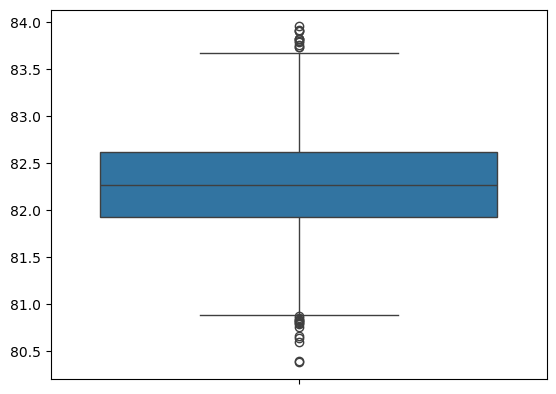

In [145]:
sns.boxplot(mu_infant.flatten())

<Axes: >

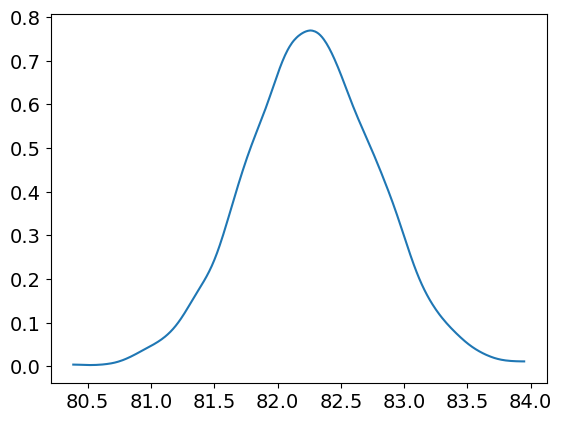

In [146]:
az.plot_kde(mu_infant)

Es una disribución normal centrada en 82.25 aproximadamente. Con un rango de 80.5 a 84.5.

## 4.

Graficar:

- El intervalo de credibilidad al 89% de la altura para cada peso.
- El intervalo de credibilidad al 89% de la altura promedio para cada peso.
- La altura promedio para cada peso.
- Los puntos correspondientes a cada individuo.

Pesos:

Text(0, 0.5, 'Height')

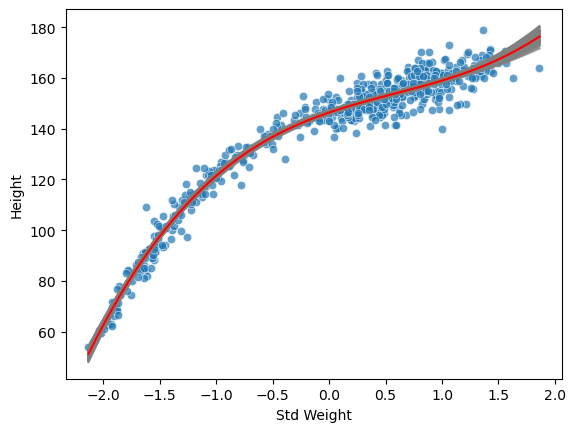

In [ ]:
m_post = posterior.sample(544)
post_mu = (m_post['alpha'].values + m_post['beta_1'].values * ((w_sorted).reshape(-1,1)) + m_post['beta_2'].values * ((w_sorted**2).reshape(-1,1)) + m_post['beta_3'].values * ((w_sorted**3).reshape(-1,1)))

sns.scatterplot(x = 'weight', y = 'height', alpha = 0.7, data = howell)
plt.plot(w_sorted, post_mu, color='grey', alpha=0.6)
plt.plot(w_sorted, mu_avg, color='red')
plt.xlabel('Std Weight')
plt.ylabel('Height')

In [150]:
with height_model:
    height_post = pm.sample_posterior_predictive(idata)

Sampling: [height]


Intervalo de credibilidad de la altura:

c:\Users\Rafa\anaconda3\envs\mebo2024_v4\lib\site-packages\arviz\plots\hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'Height')

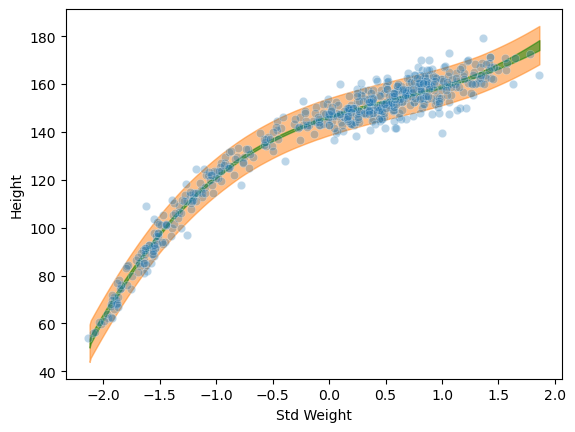

In [168]:
az.plot_hdi(w, height_post.posterior_predictive['height'], hdi_prob=0.89)
az.plot_hdi(w_sorted, post_mu.T, color='green', hdi_prob=0.89)

sns.scatterplot(x = 'weight', y = 'height', data = howell, alpha = 0.3)
plt.xlabel('Std Weight')
plt.ylabel('Height')

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>